## Çok sınıflı sınıflandırma (Multiclass classification)

* Önceki görevde ikili (binary) bir sınıflandırma problemini çözdük.  
* Peki ya **çok sınıflı (multiclass) bir sınıflandırma problemi**?

🎯 Egzersizin Amaçları:
- Çok sınıflı bir sınıflandırma problemi için tasarlanmış bir Sinir Ağı (Neural Network) yazmak
- Bu modelin ne kadar kolay **overfit** olabileceğini gözlemlemek… !

## (1) Bir `Blobs` veri kümesi oluşturun

📚 Sklearn’deki **`make_blobs`** fonksiyonu [(dokümantasyona bakınız)](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) aşağıdakileri üretmenize olanak tanır:
- İstenilen sayıda veri örneği (`n_samples` parametresi)
- Her veri örneği için istenilen sayıda özellik (`n_features` parametresi)
- İstenilen sayıda sınıf/kategori (`centers` parametresi)
- Sınıflar arasındaki mesafe (`cluster_std` parametresi)

💡 Ayrıca, verinin **deterministik** olarak (aynı şekilde) üretilmesini ve tekrar edilebilir olmasını sağlayan `random_state` parametresi de vardır.


❓ Belgelere göre:

👽 Aşağıdakilerle bir ***blobs*** veri kümesi oluşturun:
- 1200 örnek
- Örnek başına 8 özellik
- 7 veri kategorisi
- Kategoriler arasındaki mesafe 8

🔮 1'e eşit bir `random_state` seçin.

📏 Şekli yazdırın ve `X` için (1200, 8) ve `y` için (1200,) ile eşleştiğini kontrol edin ❓

In [1]:
from sklearn.datasets import make_blobs

# Parametrelerin tanımlanması
n_samples = 1200
n_features = 8
centers = 7
cluster_std = 8
random_state = 1

# Veri kümesinin üretilmesi
X, y = make_blobs(n_samples=n_samples, 
                  n_features=n_features, 
                  centers=centers, 
                  cluster_std=cluster_std, 
                  random_state=random_state)

# Şekillerin (Shape) kontrol edilmesi
print(f"X'in şekli: {X.shape}") # Beklenen: (1200, 8)
print(f"y'nin şekli: {y.shape}") # Beklenen: (1200,)

# İlk birkaç y değerine göz atalım (0 ile 6 arasında sınıflar)
print(f"İlk 10 etiket: {y[:10]}")

X'in şekli: (1200, 8)
y'nin şekli: (1200,)
İlk 10 etiket: [2 2 5 1 2 5 4 2 0 1]


❓ _matplotlib_ kullanarak bu blob veri kümesinin iki (rastgele) boyutunun dağılım grafiğini çizin. Her nokta, ait olduğu kategoriye göre renklendirilmelidir. ❓

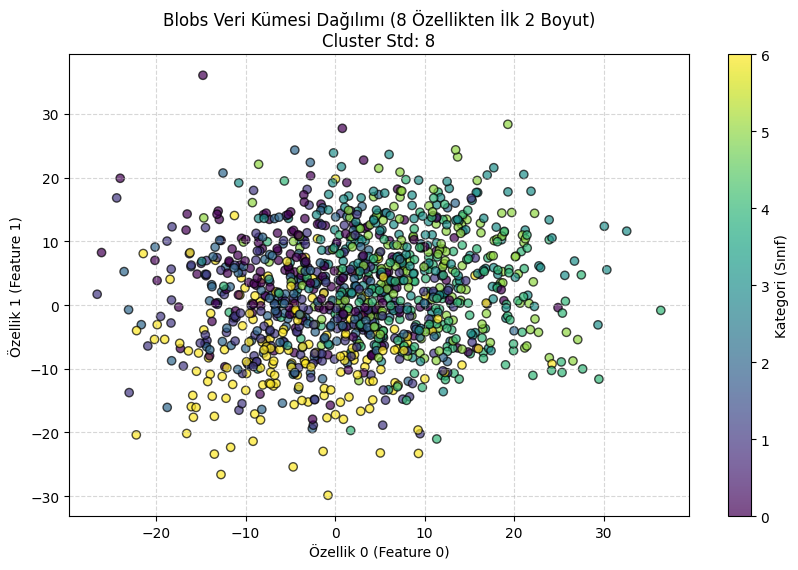

In [2]:
import matplotlib.pyplot as plt

# Görselleştirme için figür boyutunu ayarlayalım
plt.figure(figsize=(10, 6))

# X matrisinden ilk iki sütunu (0. ve 1. özellik) seçiyoruz
# c=y parametresi noktaları kategorilerine göre renklendirir
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k', alpha=0.7)

# Renklerin hangi kategoriye ait olduğunu gösteren bir renk çubuğu (legend) ekleyelim
plt.colorbar(scatter, label='Kategori (Sınıf)')

# Grafik başlıkları ve etiketler
plt.title(f'Blobs Veri Kümesi Dağılımı (8 Özellikten İlk 2 Boyut)\nCluster Std: {cluster_std}')
plt.xlabel('Özellik 0 (Feature 0)')
plt.ylabel('Özellik 1 (Feature 1)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

❓ Diğer boyutlarda da aynı işlemi tekrarlayın. Veri noktalarının kolayca ayrılmadığını görsel olarak görebilirsiniz ❓

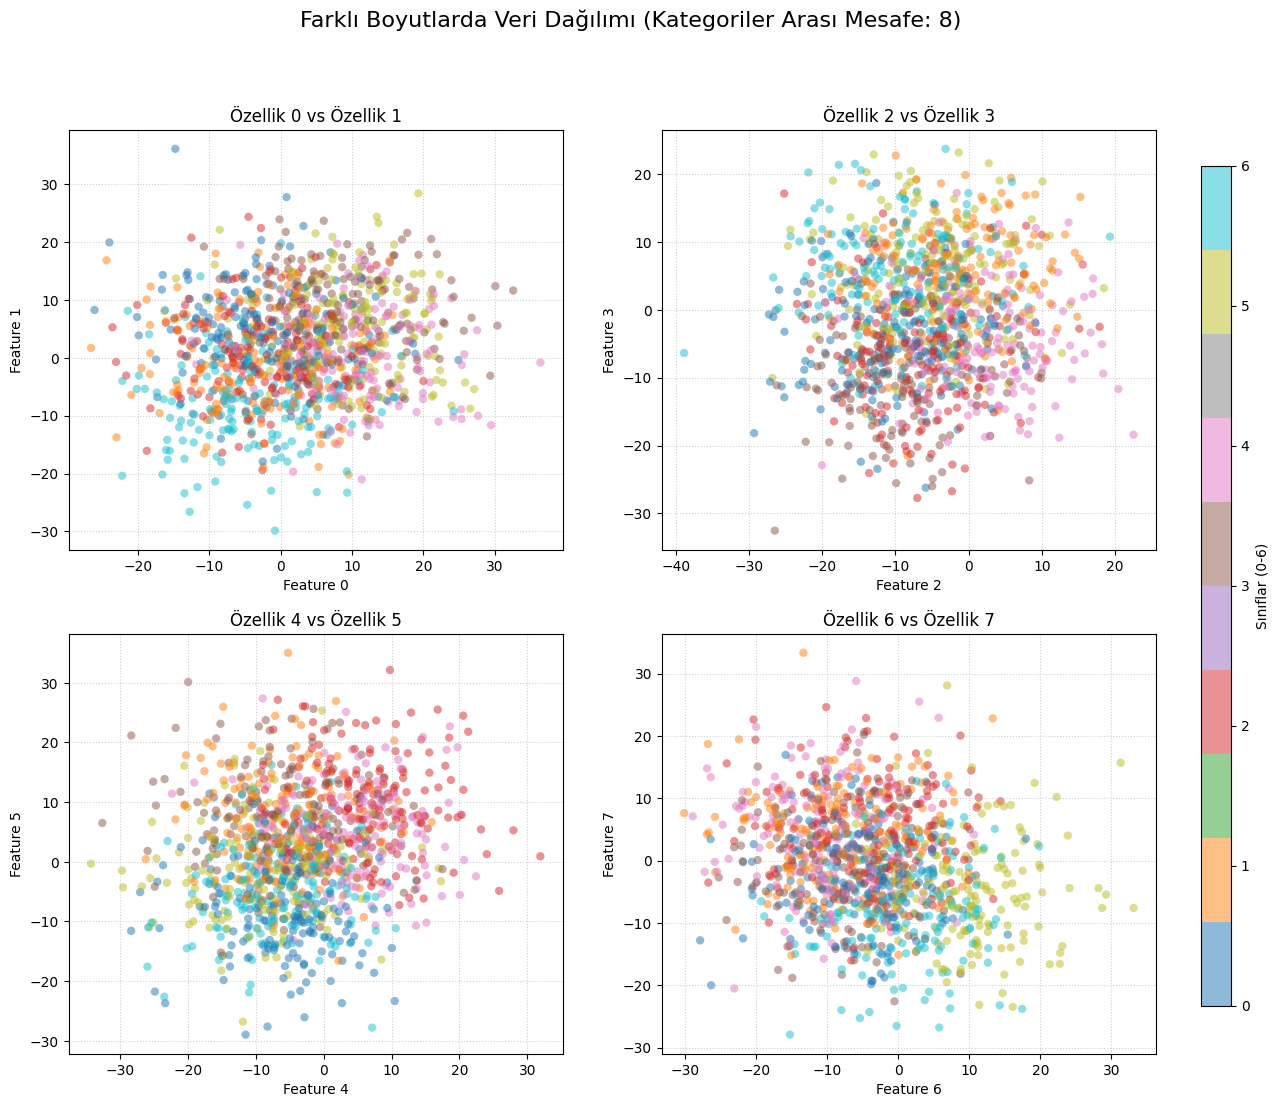

In [3]:
import matplotlib.pyplot as plt

# 2x2'lik bir figür oluşturalım
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'Farklı Boyutlarda Veri Dağılımı (Kategoriler Arası Mesafe: {cluster_std})', fontsize=16)

# Karşılaştırılacak özellik çiftleri
feature_pairs = [(0, 1), (2, 3), (4, 5), (6, 7)]

for i, (f1, f2) in enumerate(feature_pairs):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Noktaları çizdirelim
    scatter = ax.scatter(X[:, f1], X[:, f2], c=y, cmap='tab10', alpha=0.5, edgecolors='none')
    
    ax.set_title(f'Özellik {f1} vs Özellik {f2}')
    ax.set_xlabel(f'Feature {f1}')
    ax.set_ylabel(f'Feature {f2}')
    ax.grid(True, linestyle=':', alpha=0.6)

# Renk çubuğunu ekleyelim
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(scatter, cax=cbar_ax, label='Sınıflar (0-6)')

plt.show()

## (2) Çok sınıflı sınıflandırma probleminin hedefini kodlama

👉 Şu an için hedef `y`, giriş verisinin ait olduğu kategoriyi temsil eden **tamsayılar listesidir**. Şöyle görünür:  
`[3, 2, 2, 3, 0, 5, 1, 1, 0, 5, ...]`  
(bu örnekte 0’dan 6’ya kadar **7 kategori** vardır).

🧑🏻‍🏫 Ancak **Tensorflow/Keras’ta kategorik problemler için hedef/çıktı (`target/output`) aşağıdaki şekilde encode edilmelidir**:

```
[
[0, 0, 0, 1, 0, 0, 0], 
[0, 0, 1, 0, 0, 0, 0], 
[0, 0, 1, 0, 0, 0, 0], 
[1, 0, 0, 0, 0, 0, 0], 
[0, 0, 0, 0, 0, 1, 0], 
[0, 1, 0, 0, 0, 0, 0],
[0, 1, 0, 0, 0, 0, 0],
[1, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 1],
...
]
```


Burada:
- satır sayısı, **gözlem sayısına** eşittir  
- sütun sayısı, **farklı kategori sayısına** eşittir  

👉 Her sütun bir **kategoriyi** temsil eder.  

👉 Her satır bir **hedefi** temsil eder; `1` değeri, giriş verisinin ait olduğu kategoriyi gösterir.  

Bir satırı, olasılık vektörü olarak düşünebilirsiniz.

```
Örnek:
| Cat 0 | Cat 1 | Cat 2 | Cat 3 | Cat 4 | Cat 5 | Cat 6 |
|-------|-------|-------|-------|-------|-------|-------|
| 0     | 0     | 0     | 1     | 0     | 0     | 0     |

Bu, ilgili satırın %100 olasılıkla Cat 3’e ait olduğu anlamına gelir.
Cat 3
```


---

💡 `y`’yi kategorik hale dönüştürmek için **Tensorflow/Keras içindeki `to_categorical`** fonksiyonunu kullanın.

<details>
    <summary><i>Tensorflow/Keras’taki <code>to_categorical</code> ile Scikit-Learn’deki <code>OneHotEncoder</code> arasında bir benzerlik var mı?</i></summary>

Evet! **`to_categorical`**, Sklearn’deki `OneHotEncoder` gibi çalışır;  
ancak burada bir **kategorik feature** değil, **kategorik target (hedef)** encode edilir.

</details>

---

❓ **Kategorik hedefin kodlanması**:  `y` yazdırın, ardından *to_categorical* işlevini *`y`* üzerinde uygulayın ve *y'nin kategorize edilmiş halini* `y_cat` adlı bir değişkene kaydedin. ❓

In [4]:
from tensorflow.keras.utils import to_categorical

# 1. Orijinal y'nin ilk 10 değerini görelim
print("Orijinal y (ilk 10 örnek):")
print(y[:10])

# 2. to_categorical fonksiyonu ile kodlama (7 kategori olduğunu belirtiyoruz)
y_cat = to_categorical(y, num_classes=7)

# 3. Sonucu yazdıralım
print("\nKategorize edilmiş y_cat (ilk 10 örnek):")
print(y_cat[:10])

# 4. Şekil (shape) kontrolü
print(f"\ny_cat matrisinin şekli: {y_cat.shape}")

2026-01-20 14:38:17.224193: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-20 14:38:17.231990: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-20 14:38:17.297106: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-20 14:38:17.380439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-20 14:38:17.461209: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

Orijinal y (ilk 10 örnek):
[2 2 5 1 2 5 4 2 0 1]

Kategorize edilmiş y_cat (ilk 10 örnek):
[[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]

y_cat matrisinin şekli: (1200, 7)


## (3) Çok Sınıflı Sınıflandırma Görevi için Sinir Ağı

❓ **Hold-out yöntemi**: Veri kümesi $X$ ve $y_{cat}$ 'i _train_ ve _test_ kümelerine ayırın (boyut: 70/30%)

Not: Değişkenleri `X_train`, `X_test`, `y_train` ve `y_test` olarak adlandırın ❓

In [5]:
from sklearn.model_selection import train_test_split

# Veri kümesini ayırıyoruz (%70 Eğitim, %30 Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y_cat, 
    test_size=0.30, 
    random_state=1 # Sonuçların her seferinde aynı olması için
)

# Boyutları kontrol edelim
print(f"X_train boyutu: {X_train.shape}") # (840, 8)
print(f"X_test boyutu:  {X_test.shape}")  # (360, 8)
print(f"y_train boyutu: {y_train.shape}") # (840, 7)
print(f"y_test boyutu:  {y_test.shape}")  # (360, 7)

X_train boyutu: (840, 8)
X_test boyutu:  (360, 8)
y_train boyutu: (840, 7)
y_test boyutu:  (360, 7)


Derin Öğrenmede, herhangi bir Makine Öğrenimi algoritmasında olduğu gibi, sayısal özellikleriniz ölçeklendirilmelidir.

❓ **Ölçeklendirme**: Eğitim kümesine bir Sklearn [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) uydurun ve hem eğitim kümenizi hem de test kümenizi dönüştürün ❓

In [8]:
from tensorflow.keras import Sequential, layers, Input
from sklearn.preprocessing import StandardScaler

# 1. Ölçeklendiriciyi (scaler) tanımlayalım
scaler = StandardScaler()

# 2. Ölçeklendiriciyi EĞİTİM verisine uyduralım (fit) ve eğitim verisini dönüştürelim (transform)
# Not: Sadece X_train üzerinde 'fit' yapıyoruz çünkü test verisindeki bilgilerin eğitime sızmasını (data leakage) istemiyoruz.
X_train_scaled = scaler.fit_transform(X_train)

# 3. Test verisini sadece dönüştürüyoruz (transform)
X_test_scaled = scaler.transform(X_test)

# Kontrol: İlk örneğin ölçeklendirilmiş haline bakalım
print("Ölçeklendirilmiş ilk eğitim örneği:")
print(X_train_scaled[0])

Ölçeklendirilmiş ilk eğitim örneği:
[ 0.02078128 -0.49734486  0.43026988 -0.60957967 -0.60347123  1.18701726
 -1.6715323   2.58990668]


❓ **Modeli başlatma**: Aşağıdaki işlevi tamamlayarak aşağıdaki özelliklere sahip bir model oluşturun/başlatın:
- İlk katman:
   - 50 nöron
   - `relu` aktivasyonu
   - Doğru giriş boyutu
- Çıkış katmanı:
   - Çok sınıflı sınıflandırma görevi için tasarlanmış
   - Her sınıfa ait olma olasılıklarını çıktı olarak veren ❓

In [9]:
def initialize_model():

    #############################
    #  1 - Model mimarisi       #
    #############################
    model = Sequential()

    # Giriş katmanı: 8 adet özelliğimiz (feature) olduğu için shape=(8,)
    model.add(Input(shape=(8,)))

    # İlk gizli katman: 50 nöron ve ReLU aktivasyonu
    model.add(layers.Dense(50, activation='relu'))

    # Çıkış katmanı: 
    # 7 sınıfımız olduğu için 7 nöron.
    # Olasılık dağılımı üretmek için 'softmax' aktivasyonu.
    model.add(layers.Dense(7, activation='softmax'))

    #############################
    #  2 - Optimizasyon Yöntemi #
    #############################
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

# Modeli başlatalım
model = initialize_model()

# Modelin yapısını kontrol edelim
model.summary()

2026-01-20 14:43:03.038365: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-01-20 14:43:03.038919: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 807 (3.15 KB)

 Trainable params: 807 (3.15 KB)

 Non-trainable params: 0 (0.00 B)

❓  Modelde kaç parametre (diğer adıyla ağırlık) vardır? ❓

In [10]:
total_params = model.count_params()
print(f"\nModeldeki toplam parametre sayısı: {total_params}")


Modeldeki toplam parametre sayısı: 807


❓ **Modeli uydurma**: Modelinizi 50 dönemlik tren verilerine uydurun ve geçmişi çizin ❓

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1518 - loss: 2.0637 - val_accuracy: 0.1726 - val_loss: 1.9685
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2247 - loss: 1.8660 - val_accuracy: 0.2917 - val_loss: 1.7898
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3527 - loss: 1.7009 - val_accuracy: 0.4286 - val_loss: 1.6455
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5000 - loss: 1.5604 - val_accuracy: 0.5595 - val_loss: 1.5168
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5804 - loss: 1.4351 - val_accuracy: 0.6190 - val_loss: 1.4057
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6443 - loss: 1.3256 - val_accuracy: 0.6429 - val_loss: 1.3011
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6622 - loss: 1.2288 - val_accuracy: 0.6726 - val_loss: 1.2139
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6607 - loss: 1.1457 - val_accuracy: 0.6667 - val_loss:

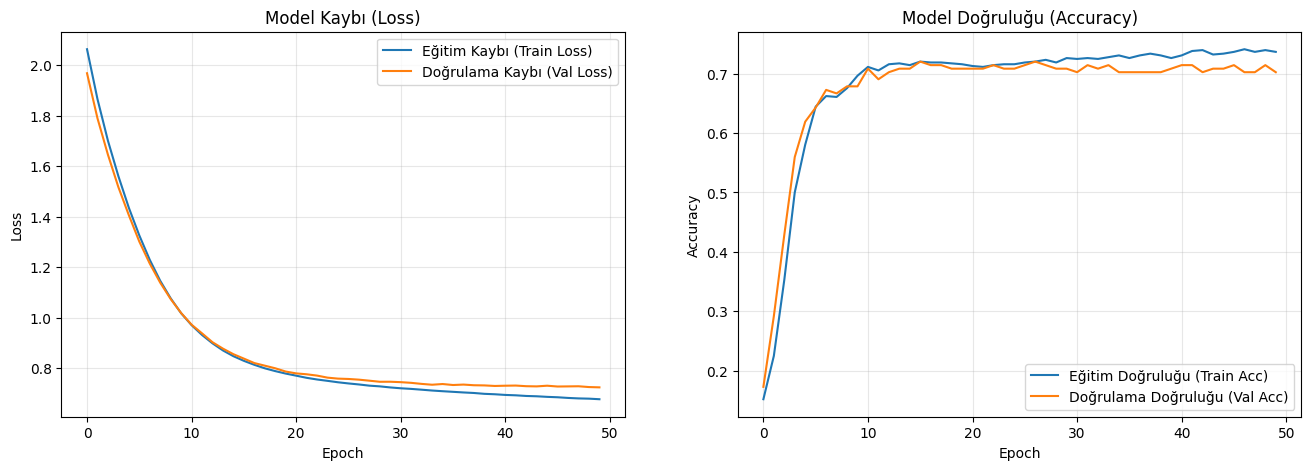

In [11]:
import matplotlib.pyplot as plt

# 1. Modeli Eğitme
# epochs=50: Tüm veri seti üzerinden 50 tam tur geçilecek
# batch_size=32: Model her seferinde 32 örneği inceleyip ağırlıkları güncelleyecek
# validation_split=0.2: Eğitim verisinin %20'si doğrulama için ayrılır
history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2,
    verbose=1
)

# 2. Geçmişi (History) Görselleştirme
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    # --- Loss (Kayıp) Grafiği ---
    ax1.plot(history.history['loss'], label='Eğitim Kaybı (Train Loss)')
    ax1.plot(history.history['val_loss'], label='Doğrulama Kaybı (Val Loss)')
    ax1.set_title('Model Kaybı (Loss)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- Accuracy (Doğruluk) Grafiği ---
    ax2.plot(history.history['accuracy'], label='Eğitim Doğruluğu (Train Acc)')
    ax2.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu (Val Acc)')
    ax2.set_title('Model Doğruluğu (Accuracy)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.show()

plot_history(history)

❓ **Değerlendirme**:  Modelinizi test setinde değerlendirin ve doğruluğu yazdırın ❓

In [12]:
# Modelin test seti üzerinde değerlendirilmesi
# verbose=0 kullanarak gereksiz çıktıları gizliyoruz
results = model.evaluate(X_test_scaled, y_test, verbose=0)

# evaluate() fonksiyonu [loss, accuracy] şeklinde bir liste döner
test_loss = results[0]
test_accuracy = results[1]

print(f"Test Kaybı (Loss): {test_loss:.4f}")
print(f"Test Doğruluğu (Accuracy): %{test_accuracy * 100:.2f}")

Test Kaybı (Loss): 0.9588
Test Doğruluğu (Accuracy): %67.22


❓ 🤔 Bu iyi bir puan mı? Bunu bir tür karşılaştırma değeriyle karşılaştırmalısınız. Bu durumda, rastgele bir tahminle ne kadar puan elde edilebilir? Bu temel puanı `accuracy_baseline` değişkeninde saklayın. ❓

(Bunun için kod yazmanıza gerek yok, sadece veri setimizin nasıl oluşturulduğunu düşünün.)

In [13]:
accuracy_baseline = 1/7

🧪 **Kodunu Test Et**

In [14]:
from nbresult import ChallengeResult
result = ChallengeResult('baseline',
                         accuracy=accuracy_baseline)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/egkpnr/.pyenv/versions/workintech_current/bin/python
cachedir: .pytest_cache
rootdir: /home/egkpnr/code/EGkpnr/S18D2-S-/S18D2-S-Data-multiclass-classification/tests
plugins: anyio-4.8.0, dash-3.3.0, typeguard-4.4.2, langsmith-0.6.0
collecting ... collected 1 item

test_baseline.py::TestBaseline::test_accuracy PASSED                     [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/baseline.pickle

git commit -m 'Completed baseline step'

git push origin master



❗ 👀 Bekle ... Kayıp grafiğine daha yakından bakarsan, 50 dönemden sonra da kayıp hala azalmaya devam ediyor gibi görünüyor. Neden bu kadar erken durduruyorsun ❓❗

❓ Modeli yeniden başlatıp bu sefer 1000 dönemle tekrar çalıştıralım ve geçmişi tekrar grafiğe çizelim. ❓

1000 Epoch'luk eğitim başladı... Bu işlem biraz zaman alabilir.
Eğitim tamamlandı!


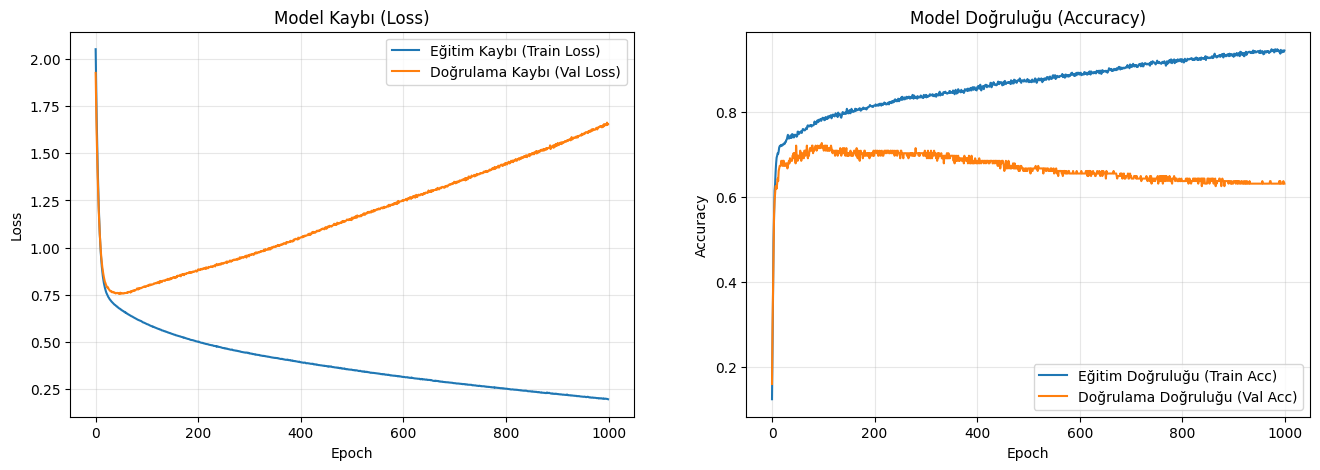

In [15]:
# 1. Modeli sıfırdan başlatıyoruz (Önceki öğrenilenleri unutması için)
model = initialize_model()

# 2. Modeli 1000 dönem (epoch) boyunca eğitiyoruz
print("1000 Epoch'luk eğitim başladı... Bu işlem biraz zaman alabilir.")
history_1000 = model.fit(
    X_train_scaled, 
    y_train, 
    validation_split=0.2,
    epochs=1000, 
    batch_size=32, 
    verbose=0 # Ekranda 1000 satır görmemek için sessiz mod
)
print("Eğitim tamamlandı!")

# 3. Geçmişi tekrar çizelim
plot_history(history_1000)

❓ **Bir modeli daha uzun süre eğitirken...** ❓
- Yeni kayıp hakkında ne söyleyebilirsiniz?
- Modelinizi test setinde bir kez daha değerlendirin ve doğruluğu yazdırın.

In [16]:
# 1000 epoch eğitilmiş modelin değerlendirilmesi
final_results = model.evaluate(X_test_scaled, y_test, verbose=0)

final_loss = final_results[0]
final_accuracy = final_results[1]

print(f"1000 Epoch Sonrası Test Kaybı (Loss): {final_loss:.4f}")
print(f"1000 Epoch Sonrası Test Doğruluğu (Accuracy): %{final_accuracy * 100:.2f}")

# Önceki %67.22 skoruyla kıyaslama
print(f"\nDeğişim: %{(final_accuracy - 0.6722) * 100:+.2f}")

1000 Epoch Sonrası Test Kaybı (Loss): 2.3541
1000 Epoch Sonrası Test Doğruluğu (Accuracy): %59.17

Değişim: %-8.05


* 😁 Tren setinde hesaplanan kayıp, 50 epok ile karşılaştırıldığında 1000 epok ile daha küçük görünüyor.
* 😟 Anc ak test setindeki doğruluk, 50 epok ile karşılaştırıldığında 1000 epok ile daha kötü...

❓ Bu fenomene ne denir? ❓

*Overfitting denir*

---

🤔 Bunun olmasını önlemek için ne yapmalıyız? 

<details>
    <summary><i>Olası seçenekler</i></summary>
    

⚠️ Sinir ağlarında aşırı uyumun olmasını önlemek için, örneğin şunları yapabiliriz:
1. Sinir ağının gürültülü veri noktalarından çok fazla öğrenmesini önlemek için ***makul sayıda dönem*** seçin
2. ***Erken Durdurma*** kriteri, yani _.fit()_ 📆 cf. ***Derin Öğrenme > Optimize Ediciler, Kayıp, Uydurma***

</details>    

---


❓ Test kaybının pratikte ne zaman tekrar artmaya başladığını görsel olarak kontrol edelim.  Aşağıdaki komutu çalıştırın ve geçmişi çizin❓

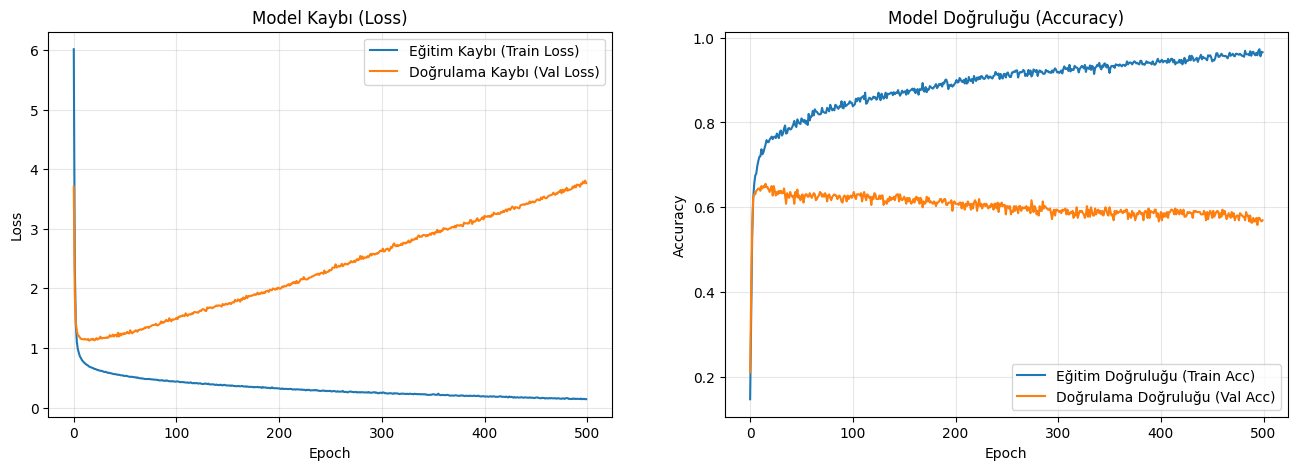

In [17]:
model = initialize_model()

history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    epochs=500,
                    batch_size=16,
                    verbose=0)
plot_history(history)

😱 Ama durun... test setini kullanırsak hile yapmış olmaz mıyız? Evet, oluruz. Ama yine sabırlı olun. ***Derin Öğrenme - Optimize Ediciler, Kayıp, Uydurma*** bölümünde, bunu önlemek için ***Doğrulama Seti*** adını verdiğimiz şeyi kullanacağız!

🧘🏻‍♀️ Şimdilik, sonraki sorulara geçelim!

❓ **Ağı değerlendirme**: <span style="color:blue">eğitim seti</span> ve <span style="color:orange">test seti</span> üzerindeki kayıp ve doğruluk değerlerini grafik olarak gösterin. Bu konuda ne söyleyebilirsiniz? ❓ 

In [21]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

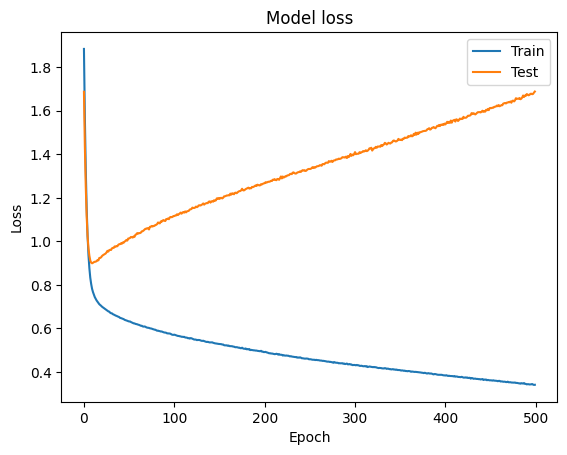

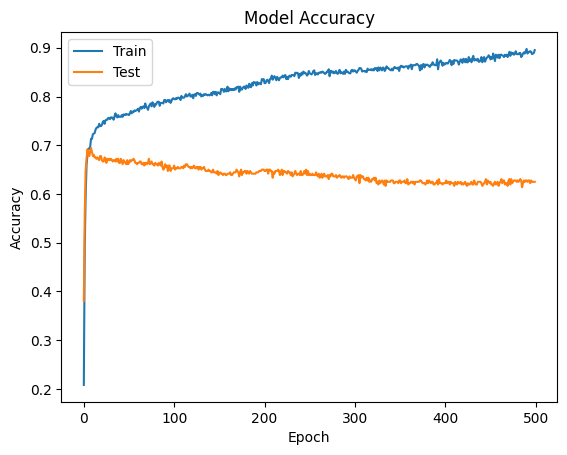

In [22]:
plot_loss_accuracy(history)

🤔 Derin Öğrenme modelimiz neden bu kadar kolay aşırı uyum sağlıyor?

😳 Düşünün, sinir ağımız sadece 8 özellik içeren bir veri kümesinden basit bir sınıflandırma görevi için ~800 parametre öğrenmek zorunda! Üstelik, uyum sağlamak için toplamda sadece ~800 veri noktamız var! Model, eğitim kümesindeki her noktanın tam sınıfını neredeyse “öğrenebilir”. 

Buna karşılık, basit bir Lojistik Regresyon, bu blob veri kümesinin kalıplarını yakalamak için sadece 9 parametreyi öğrenmek zorunda kalırdı! 

😏 Derin öğrenme etkileyici bir kavramdır, ancak basit makine öğrenimi görevleri için açıkça aşırı ve gereksiz bir seçenek olabilir!

⭐️ Aşağıdakiler için son derece yararlı olacaktır:
- 📸 Görüntü işleme
- 💹 Zaman serileri
- 🗣 Doğal dil işleme

---

🏁 Tebrikler!

💾 Not defterinizi `git add/commit/push` yapmayı unutmayın...

🚀 ... ve bir sonraki göreve geçin!